# Imports and config

Since imports include llana.cpp Python bindings, the llama.cpp and llama.cpp-python steps of Setup section must be completed first.

Additionally, loading llava_cpp is currently broken - PR is pending, in the meantime, manually edited `llama_cpp/llava_cpp.py` - line 39: else expression should contain `pathlib.Path(_libllava_override_path)` (this will likely be resolved by the time I push this update)

In [3]:
# Depending on support
# %matplotlib notebook
%matplotlib inline

from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from time import sleep
import numpy as np
import pandas as pd
import os
import json

# Requires https://github.com/abetlen/llama-cpp-python/pull/1782
os.environ['LLAMA_CPP_LIB_PATH'] = './llama.cpp/build/src'
os.environ['LLAVA_CPP_LIB'] = './llama.cpp/build/examples/llava'
from llama_cpp import llama_cpp, llava_cpp
from ctypes import byref, c_int, c_char, c_char_p

pd.options.display.float_format = lambda x: '%.2f' % x
plt.rcParams['figure.figsize'] = [10.0, 8.0]

# Setup

We download and build project dependencies. Do note that [git-lfs](https://git-lfs.com/) is required to clone the repos containing the models. The outputs of build scripts and such can be quite verbose, if scrolling does not enable automatically, in Spyder Notebook, right click the output pane and select "Enable scrolling for Outpus" or left click the blank space to the left of said output pane.

In [ ]:
# llama.cpp
# TODO build everything with cmake instead (should be simple, but test afterwards)
! git clone https://github.com/ggerganov/llama.cpp.git
! cd llama.cpp && make
! cd llama.cpp && cmake -B build -DBUILD_SHARED_LIBS=1
! cd llama.cpp && cmake --build build --config Release --target llava_shared
! mv ./llama.cpp/build/examples/llava/libllava_shared.so ./llama.cpp/build/examples/llava/libllava.so

In [ ]:
# llama.cpp-python
# TODO llama-cpp-python DOES have conda-forge feedstock, but CMAKE_ARGS cannot be specified in env.yml
# However, this should work: CMAKE_ARGS="-DLLAMA_BUILD=OFF" conda env create -f env.yml
# Possibly create a create-env.sh with this line, or add this to README.md
! export LLAMA_CPP_LIB_PATH=./llama.cpp/build/src && CMAKE_ARGS="-DLLAMA_BUILD=OFF" pip install llama-cpp-python

In [ ]:
# LLaVA 1.5 7B
! git lfs clone https://huggingface.co/liuhaotian/llava-v1.5-7b
! git lfs clone https://huggingface.co/openai/clip-vit-large-patch14-336
! cd llama.cpp && python ./examples/llava/llava_surgery.py -m ../llava-v1.5-7b
! cd llama.cpp && python ./examples/llava/convert_image_encoder_to_gguf.py -m ../clip-vit-large-patch14-336 --llava-projector ../llava-v1.5-7b/llava.projector --output-dir ../llava-v1.5-7b
! cd llama.cpp && python ./examples/convert_legacy_llama.py ../llava-v1.5-7b --skip-unknown

In [ ]:
# LLaVa 1.6 vicuna 7B
! git lfs clone https://huggingface.co/liuhaotian/llava-v1.6-vicuna-7b
! git lfs clone https://huggingface.co/openai/clip-vit-large-patch14-336
! cd llama.cpp && python ./examples/llava/llava_surgery_v2.py -C -m ../llava-v1.6-vicuna-7b/
! mkdir llava-v1.6-vicuna-7b/vit
! cp llava-v1.6-vicuna-7b/llava.clip llava-v1.6-vicuna-7b/vit/pytorch_model.bin
! cp llava-v1.6-vicuna-7b/llava.projector llava-v1.6-vicuna-7b/vit/
! curl -s -q https://huggingface.co/cmp-nct/llava-1.6-gguf/raw/main/config_vit.json -o llava-v1.6-vicuna-7b/vit/config.json
! cd llama.cpp && python ./examples/llava/convert_image_encoder_to_gguf.py -m ../llava-v1.6-vicuna-7b/vit --llava-projector ../llava-v1.6-vicuna-7b/vit/llava.projector --output-dir ../llava-v1.6-vicuna-7b/vit --clip-model-is-vision
! cd llama.cpp && python ./examples/convert_legacy_llama.py ../llava-v1.6-vicuna-7b/ --skip-unknown

In [ ]:
# MiniCPM 2.5
# TODO this crashes with high RAM usage - might be asking for 7x4GB for a F32 model?
# TODO also "make llama-minicpmv-cli" fails: "undefined reference to `ggml_print_backtrace'"
! git lfs clone https://huggingface.co/openbmb/MiniCPM-Llama3-V-2_5
! cd llama.cpp && python ./examples/llava/minicpmv-surgery.py -m ../MiniCPM-Llama3-V-2_5
! cd llama.cpp && python ./examples/llava/minicpmv-convert-image-encoder-to-gguf.py -m ../MiniCPM-Llama3-V-2_5 --minicpmv-projector ../MiniCPM-Llama3-V-2_5/minicpmv.projector --output-dir ../MiniCPM-Llama3-V-2_5/ --image-mean 0.5 0.5 0.5 --image-std 0.5 0.5 0.5 --minicpmv_version 2
! cd llama.cpp && python ./convert_hf_to_gguf.py ../MiniCPM-Llama3-V-2_5/model

In [ ]:
# MiniCPM 2.6
! git lfs clone https://huggingface.co/openbmb/MiniCPM-V-2_6
! cd llama.cpp && python ./examples/llava/minicpmv-surgery.py -m ../MiniCPM-V-2_6
! cd llama.cpp && python ./examples/llava/minicpmv-convert-image-encoder-to-gguf.py -m ../MiniCPM-V-2_6 --minicpmv-projector ../MiniCPM-V-2_6/minicpmv.projector --output-dir ../MiniCPM-V-2_6/ --image-mean 0.5 0.5 0.5 --image-std 0.5 0.5 0.5 --minicpmv_version 3
! cd llama.cpp && python ./convert_hf_to_gguf.py ../MiniCPM-V-2_6/model

In [ ]:
# Mobile VLM V1 1.7B
! git lfs clone https://huggingface.co/mtgv/MobileVLM-1.7B
! git lfs clone https://huggingface.co/openai/clip-vit-large-patch14-336
! cd llama.cpp && python ./examples/llava/llava_surgery.py -m ../MobileVLM-1.7B
! cd llama.cpp && python ./examples/llava/convert_image_encoder_to_gguf.py -m ../clip-vit-large-patch14-336 --llava-projector ../MobileVLM-1.7B/llava.projector --output-dir ../MobileVLM-1.7B --projector-type ldp
! cd llama.cpp && python ./examples/convert_legacy_llama.py ../MobileVLM-1.7B --skip-unknown

In [ ]:
# Mobile VLM V2 1.7B
! git lfs clone https://huggingface.co/mtgv/MobileVLM_V2-1.7B
! git lfs clone https://huggingface.co/openai/clip-vit-large-patch14-336
! cd llama.cpp && python ./examples/llava/llava_surgery.py -m ../MobileVLM_V2-1.7B
! cd llama.cpp && python ./examples/llava/convert_image_encoder_to_gguf.py -m ../clip-vit-large-patch14-336 --llava-projector ../MobileVLM_V2-1.7B/llava.projector --output-dir ../MobileVLM_V2-1.7B --projector-type ldpv2
! cd llama.cpp && python ./examples/convert_legacy_llama.py ../MobileVLM_V2-1.7B --skip-unknown

# Experiments

Next, different models at different quantization models and methods are evaluated. Do note that CLIP image encoder quantization is not supported by llama.cpp, hence only quantizations of the language model are considered.

In [7]:
llama_cpp.llama_backend_init()

def make_sampler(model, seed=0, temp=0.1):
    chain = llama_cpp.llama_sampler_chain_init(llama_cpp.llama_sampler_chain_default_params())
    llama_cpp.llama_sampler_chain_add(chain, llama_cpp.llama_sampler_init_top_k(40))
    llama_cpp.llama_sampler_chain_add(chain, llama_cpp.llama_sampler_init_top_p(0.95, 0))
    llama_cpp.llama_sampler_chain_add(chain, llama_cpp.llama_sampler_init_min_p(0.05, 0))
    llama_cpp.llama_sampler_chain_add(chain, llama_cpp.llama_sampler_init_temp_ext(temp, 0.0, 1.0));
    llama_cpp.llama_sampler_chain_add(chain, llama_cpp.llama_sampler_init_softmax());
    llama_cpp.llama_sampler_chain_add(chain, llama_cpp.llama_sampler_init_dist(seed));
    return chain

def sample(sampler, ctx_llama, n_past):
    token = llama_cpp.llama_sampler_sample(sampler, ctx_llama, -1)
    if not llama_cpp.llama_token_is_eog(llama_cpp.llama_get_model(ctx_llama), token):
        piece = (c_char * 15)()
        n_char = llama_cpp.llama_token_to_piece(llama_cpp.llama_get_model(ctx_llama), token, piece, 15, 0, True)
        piece = (c_char * n_char).from_buffer_copy(piece).value # TODO is the negative n handling needed?
    else:
        piece = b'</s>'
    llama_cpp.llama_decode(ctx_llama, llama_cpp.llama_batch_get_one(byref(llama_cpp.llama_token(token)), 1, n_past, 0))
    return token, piece

def experiment(model, mmproj, seed=0, n_images=20, temp=0.1, n_ctx=2048, prompt='Suggest a short caption for this image.'):
    # ========================================================
    # Load model into memory
    # ========================================================
    t = timer()
    model_params = llama_cpp.llama_model_default_params()
    model_params.n_ctx = n_ctx
    llama_model = llama_cpp.llama_load_model_from_file(model.encode(), model_params)
    ctx_clip = llava_cpp.clip_model_load(mmproj.encode(), 1)
    ctx_params = llama_cpp.llama_context_default_params()
    t_load = timer() - t
    
    # ========================================================
    # Set up validation dataset
    # ========================================================
    coco = COCO('coco/captions_val2014.json')
    rng = np.random.default_rng(seed=seed)
    ids = rng.choice(coco.getImgIds(), size=n_images)
    imgs = coco.loadImgs(ids=ids)
    anns = coco.loadAnns(coco.getAnnIds(imgIds=ids))
    
    # ========================================================
    # Run and time individual image prompts
    # ========================================================
    data = []
    for img in imgs:
        path = 'coco/images/' + img['file_name']
        if not os.path.isfile(path):
            ! curl {img['coco_url']} > {path}

        system_prompt = "A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions.\nUSER:"
        user_prompt = prompt + "\nASSISTANT:"

        print('Embed')
        t = timer() # Embed image
#        ctx_clip = llava_cpp.clip_model_load(mmproj.encode(), 1)
        embed = llava_cpp.llava_image_embed_make_with_filename(ctx_clip, -1, path.encode())
        t_embed = timer() - t

        print('Tok sys')
        t = timer() # Tokenize system prompt
        ctx_llama = llama_cpp.llama_new_context_with_model(llama_model, ctx_params)
        n_tokens = len(system_prompt.encode()) + 2 * True
        tokens = (llama_cpp.llama_token * n_tokens)()
        n_tokens = llama_cpp.llama_tokenize(llama_model, system_prompt.encode(), n_tokens, tokens, n_tokens, True, True)
        tokens = (llama_cpp.llama_token * n_tokens).from_buffer_copy(tokens) # TODO is the negative n handling needed?
        llama_cpp.llama_decode(ctx_llama, llama_cpp.llama_batch_get_one(tokens, n_tokens, 0, 0))
        t_sys = timer() - t

        print('Tok img')
        t = timer() # Tokenize image
        n_past = c_int(n_tokens)
        llava_cpp.llava_eval_image_embed(ctx_llama, embed, 2048, byref(n_past))
        n_past = n_past.value
        t_img = timer() - t

        print('Tok usr')
        t = timer() # Tokenize user prompt
        n_tokens = len(user_prompt.encode()) + 2 * False
        tokens = (llama_cpp.llama_token * n_tokens)()
        n_tokens = llama_cpp.llama_tokenize(llama_model, user_prompt.encode(), n_tokens, tokens, n_tokens, False, True)
        tokens = (llama_cpp.llama_token * n_tokens).from_buffer_copy(tokens) # TODO is the negative n handling needed?
        llama_cpp.llama_decode(ctx_llama, llama_cpp.llama_batch_get_one(tokens, n_tokens, n_past, 0))
        n_past += n_tokens
        t_usr = timer() - t
        
        print('Sample')
        t = timer()
        caption = b''
        sampler = make_sampler(model, seed, temp)
        tokens = 256
        for i in range(256):
            token, piece = sample(sampler, ctx_llama, n_past + i)
            if piece == b'</s>' or b'###' in piece:
                tokens = i + 1; break
            caption += piece
            if b'<|im_end|>' in caption or b'<|im_start|>' in caption or b'USER:' in caption:
                tokens = i + 1; break
        t_sample = timer() - t

        caption = caption.replace(b'<|im_end|>', b'').replace(b'<|im_start|>', b'').replace(b'USER:', b'').decode()
        
        data += [{'image_id': img['id'], 'caption': caption, 't_load': t_load, 't_embed': t_embed, 
            't_sys': t_sys, 't_img': t_img, 't_usr': t_usr, 't_sample': t_sample, 'tokens': tokens}]
        print(img['file_name'] + ' | ' + caption)

        llama_cpp.llama_free(ctx_llama)
        llava_cpp.llava_image_embed_free(embed)
        llama_cpp.llama_sampler_free(sampler)
        
    llava_cpp.clip_free(ctx_clip)
    llama_cpp.llama_free_model(llama_model)

    # ========================================================
    # Evaluate responses
    # ========================================================
    with open('coco/results.json', 'w') as f:
        json.dump(data, f, indent=4)
    cocoRes = coco.loadRes('coco/results.json')
    cocoEval = COCOEvalCap(coco, cocoRes)
    # sorted(...) mitigates inconsistent behavior of individual metrics
    cocoEval.params['image_id'] = sorted(cocoRes.getImgIds())
    cocoEval.evaluate()
    
    # ========================================================
    # Structure results
    # ========================================================
    df = pd.DataFrame(cocoEval.evalImgs).set_index('image_id')
    # 'f' here stands for f-score, other options include 'pr'(ecision), 're'(call), 'tp', 'fp', 'fn'
    df['SPICE All'] = [i['All']['f'] for i in df['SPICE']]
    df['SPICE Obj'] = [i['Object']['f'] for i in df['SPICE']]
    df['SPICE Rel'] = [i['Relation']['f'] for i in df['SPICE']]
    df = df.drop('SPICE', axis=1)
    df = df.join(pd.DataFrame(data).set_index('image_id'))
    return df

In [5]:
experiment_results = []

### LLaVA v1.5 7b, F16:

In [ ]:
print(f'MODEL SIZE: {os.path.getsize("llava-v1.5-7b/llava-v1.5-7B-F16.gguf") / 1024**3:.2f}G')
df = experiment(
    model='llava-v1.5-7b/llava-v1.5-7B-F16.gguf',
    mmproj='llava-v1.5-7b/mmproj-model-f16.gguf',
)
display(df) # If using Spyder, consider viewing the DataFrame with the Variable Explorer (burger menu -> open console)
df['model'] = 'llava-v1.5-7B-F16'
df = df.set_index('model', append=True)
experiment_results.append(df)

### LLaVA v1.5 7b, Q5_K:

In [ ]:

! llama.cpp/llama-quantize llava-v1.5-7b/llava-v1.5-7B-F16.gguf llava-v1.5-7b/llava-v1.5-7B-Q5_K.gguf Q5_K
print(f'MODEL SIZE: {os.path.getsize("llava-v1.5-7b/llava-v1.5-7B-Q5_K.gguf") / 1024**3:.2f}G')
df = experiment(
    model='llava-v1.5-7b/llava-v1.5-7B-Q5_K.gguf',
    mmproj='llava-v1.5-7b/mmproj-model-f16.gguf',
)
display(df) # If using Spyder, consider viewing the DataFrame with the variable viewer
df['model'] = 'llava-v1.5-7B-Q5_K'
df = df.set_index('model', append=True)
experiment_results.append(df)
! rm llava-v1.5-7b/llava-v1.5-7B-Q5_K.gguf

### LLaVA v1.5 7b, Q2_K:

In [ ]:

! llama.cpp/llama-quantize llava-v1.5-7b/llava-v1.5-7B-F16.gguf llava-v1.5-7b/llava-v1.5-7B-Q2_K.gguf Q2_K
print(f'MODEL SIZE: {os.path.getsize("llava-v1.5-7b/llava-v1.5-7B-Q2_K.gguf") / 1024**3:.2f}G')
df = experiment(
    model='llava-v1.5-7b/llava-v1.5-7B-Q2_K.gguf',
    mmproj='llava-v1.5-7b/mmproj-model-f16.gguf',
)
display(df) # If using Spyder, consider viewing the DataFrame with the variable viewer
df['model'] = 'llava-v1.5-7B-Q2_K'
df = df.set_index('model', append=True)
experiment_results.append(df)
! rm llava-v1.5-7b/llava-v1.5-7B-Q2_K.gguf

### LLaVA v1.6 7b, F16:

In [ ]:

! llama.cpp/llama-quantize llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-F32.gguf llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-F16.gguf F16
print(f'MODEL SIZE: {os.path.getsize("llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-F16.gguf") / 1024**3:.2f}G')
df = experiment(
    model='llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-F16.gguf',
    mmproj='llava-v1.6-vicuna-7b/vit/mmproj-model-f16.gguf',
)
display(df) # If using Spyder, consider viewing the DataFrame with the Variable Explorer (burger menu -> open console)
df['model'] = 'llava-v1.6-7B-F16'
df = df.set_index('model', append=True)
experiment_results.append(df)
! rm llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-F16.gguf

### LLaVA v1.6 7b, Q5_K:

In [ ]:

! llama.cpp/llama-quantize llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-F32.gguf llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-Q5_K.gguf Q5_K
print(f'MODEL SIZE: {os.path.getsize("llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-Q5_K.gguf") / 1024**3:.2f}G')
df = experiment(
    model='llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-Q5_K.gguf',
    mmproj='llava-v1.6-vicuna-7b/vit/mmproj-model-f16.gguf',
)
display(df) # If using Spyder, consider viewing the DataFrame with the Variable Explorer (burger menu -> open console)
df['model'] = 'llava-v1.6-7B-Q5_K'
df = df.set_index('model', append=True)
experiment_results.append(df)
! rm llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-Q5_K.gguf

### LLaVA v1.6 7b, Q2_K:

In [ ]:

! llama.cpp/llama-quantize llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-F32.gguf llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-Q2_K.gguf Q2_K
print(f'MODEL SIZE: {os.path.getsize("llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-Q2_K.gguf") / 1024**3:.2f}G')
df = experiment(
    model='llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-Q2_K.gguf',
    mmproj='llava-v1.6-vicuna-7b/vit/mmproj-model-f16.gguf',
)
display(df) # If using Spyder, consider viewing the DataFrame with the Variable Explorer (burger menu -> open console)
df['model'] = 'llava-v1.6-7B-Q2_K'
df = df.set_index('model', append=True)
experiment_results.append(df)
! rm llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-Q_2K.gguf

### MobileVLM 1.7b, F16:

In [ ]:

! llama.cpp/llama-quantize MobileVLM-1.7B/MobileVLM-1.7B-F32.gguf MobileVLM-1.7B/MobileVLM-1.7B-F16.gguf F16
print(f'MODEL SIZE: {os.path.getsize("MobileVLM-1.7B/MobileVLM-1.7B-F16.gguf") / 1024**3:.2f}G')
df = experiment(
    model='MobileVLM-1.7B/MobileVLM-1.7B-F16.gguf',
    mmproj='MobileVLM-1.7B/mmproj-model-f16.gguf',
)
display(df) # If using Spyder, consider viewing the DataFrame with the Variable Explorer (burger menu -> open console)
df['model'] = 'MobileVLM-1.7B-F16'
df = df.set_index('model', append=True)
experiment_results.append(df)
! rm MobileVLM-1.7B/MobileVLM-1.7B-F16.gguf

### MobileVLM 1.7b, Q5_K:

In [ ]:

! llama.cpp/llama-quantize MobileVLM-1.7B/MobileVLM-1.7B-F32.gguf MobileVLM-1.7B/MobileVLM-1.7B-Q5_K.gguf Q5_K
print(f'MODEL SIZE: {os.path.getsize("MobileVLM-1.7B/MobileVLM-1.7B-Q5_K.gguf") / 1024**3:.2f}G')
df = experiment(
    model='MobileVLM-1.7B/MobileVLM-1.7B-Q5_K.gguf',
    mmproj='MobileVLM-1.7B/mmproj-model-f16.gguf',
)
display(df) # If using Spyder, consider viewing the DataFrame with the Variable Explorer (burger menu -> open console)
df['model'] = 'MobileVLM-1.7B-Q5_K'
df = df.set_index('model', append=True)
experiment_results.append(df)
! rm MobileVLM-1.7B/MobileVLM-1.7B-Q5_K.gguf

### MobileVLM 1.7b, Q2_K:

In [ ]:

! llama.cpp/llama-quantize MobileVLM-1.7B/MobileVLM-1.7B-F32.gguf MobileVLM-1.7B/MobileVLM-1.7B-Q2_K.gguf Q2_K
print(f'MODEL SIZE: {os.path.getsize("MobileVLM-1.7B/MobileVLM-1.7B-Q2_K.gguf") / 1024**3:.2f}G')
df = experiment(
    model='MobileVLM-1.7B/MobileVLM-1.7B-Q2_K.gguf',
    mmproj='MobileVLM-1.7B/mmproj-model-f16.gguf',
)
display(df) # If using Spyder, consider viewing the DataFrame with the Variable Explorer (burger menu -> open console)
df['model'] = 'MobileVLM-1.7B-Q2_K'
df = df.set_index('model', append=True)
experiment_results.append(df)
! rm MobileVLM-1.7B/MobileVLM-1.7B-Q2_K.gguf

### MobileVLM V2 1.7b, F16:

In [ ]:

! llama.cpp/llama-quantize MobileVLM_V2-1.7B/MobileVLM_V2-1.7B-F32.gguf MobileVLM_V2-1.7B/MobileVLM_V2-1.7B-F16.gguf F16
print(f'MODEL SIZE: {os.path.getsize("MobileVLM_V2-1.7B/MobileVLM_V2-1.7B-F16.gguf") / 1024**3:.2f}G')
df = experiment(
    model='MobileVLM_V2-1.7B/MobileVLM_V2-1.7B-F16.gguf',
    mmproj='MobileVLM_V2-1.7B/mmproj-model-f16.gguf',
)
display(df) # If using Spyder, consider viewing the DataFrame with the Variable Explorer (burger menu -> open console)
df['model'] = 'MobileVLM_V2-1.7B-F16'
df = df.set_index('model', append=True)
experiment_results.append(df)
! rm MobileVLM_V2-1.7B/MobileVLM_V2-1.7B-F16.gguf

### MobileVLM V2 1.7b, Q5_K:

In [ ]:

! llama.cpp/llama-quantize MobileVLM_V2-1.7B/MobileVLM_V2-1.7B-F32.gguf MobileVLM_V2-1.7B/MobileVLM_V2-1.7B-Q5_K.gguf Q5_K
print(f'MODEL SIZE: {os.path.getsize("MobileVLM_V2-1.7B/MobileVLM_V2-1.7B-Q5_K.gguf") / 1024**3:.2f}G')
df = experiment(
    model='MobileVLM_V2-1.7B/MobileVLM_V2-1.7B-Q5_K.gguf',
    mmproj='MobileVLM_V2-1.7B/mmproj-model-f16.gguf',
)
display(df) # If using Spyder, consider viewing the DataFrame with the Variable Explorer (burger menu -> open console)
df['model'] = 'MobileVLM_V2-1.7B-Q5_K'
df = df.set_index('model', append=True)
experiment_results.append(df)
! rm MobileVLM_V2-1.7B/MobileVLM_V2-1.7B-Q5_K.gguf

### MobileVLM V2 1.7b, Q2_K:

In [ ]:

! llama.cpp/llama-quantize MobileVLM_V2-1.7B/MobileVLM_V2-1.7B-F32.gguf MobileVLM_V2-1.7B/MobileVLM_V2-1.7B-Q2_K.gguf Q2_K
print(f'MODEL SIZE: {os.path.getsize("MobileVLM_V2-1.7B/MobileVLM_V2-1.7B-Q2_K.gguf") / 1024**3:.2f}G')
df = experiment(
    model='MobileVLM_V2-1.7B/MobileVLM_V2-1.7B-Q2_K.gguf',
    mmproj='MobileVLM_V2-1.7B/mmproj-model-f16.gguf',
)
display(df) # If using Spyder, consider viewing the DataFrame with the Variable Explorer (burger menu -> open console)
df['model'] = 'MobileVLM_V2-1.7B-Q2_K'
df = df.set_index('model', append=True)
experiment_results.append(df)
! rm MobileVLM_V2-1.7B/MobileVLM_V2-1.7B-Q2_K.gguf

Finally, we construct a DataFrame of all results concatenated.

In [12]:
# TODO it may be wiser to write individual experiments to .csv files
df = pd.concat(experiment_results)
with open('results.csv', 'w') as f:
    f.write(df.to_csv())

# Browse-only Imports

The following cell can be used to import packages for the Results section of this notebook without prerequisites to run the experiments being installed.

In [14]:
# Depending on support
# %matplotlib widget
%matplotlib inline

from pycocotools.coco import COCO
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

pd.options.display.float_format = lambda x: '%.2f' % x
plt.rcParams['figure.figsize'] = [10.0, 8.0]

# Results

This section of the notebook can be used with an externally obtained results file without the prerequisites required to run any of the experiments. NumPy, Pandas, Matplotlib and COCO API are still required. Model should be reloaded from the results file even if it was created in the same session to ensure uniform data layout.

In [13]:
# TODO the model names are hardcoded in multiple places now
df = pd.read_csv('results.csv')
df['model'] = pd.Categorical(df['model'], categories=[
    'llava-v1.5-7B-F16'    , 'llava-v1.5-7B-Q5_K'    , 'llava-v1.5-7B-Q2_K',
    'llava-v1.6-7B-F16'    , 'llava-v1.6-7B-Q5_K'    , 'llava-v1.6-7B-Q2_K',
    'MobileVLM-1.7B-F16'   , 'MobileVLM-1.7B-Q5_K'   , 'MobileVLM-1.7B-Q2_K',
    'MobileVLM_V2-1.7B-F16', 'MobileVLM_V2-1.7B-Q5_K', 'MobileVLM_V2-1.7B-Q2_K',
])
df = df.set_index(['image_id', 'model']).sort_index()

A complete overview of datapoints. To make the output scrollable in Spyder Notebook, right click the cell output and select the "Enable Scrolling for Outputs" option. COCO API is used to enhance the table with quick access to the ground truth of each datapoint. Image can be viewed by clicking the image id, while ground truth captions can be found by hovering a generated caption.

In [14]:
coco = COCO('coco/captions_val2014.json')

def attach_image(val, coco=coco):
    img = coco.loadImgs(ids=val)[0]
    path = 'coco/images/' + img['file_name']
#     if os.path.isfile(path):
#         return '<a target="_blank" href="{}">{}</a>'.format(path, val)
#     else:
    return '<a target="_blank" href="{}">{}</a>'.format(img['coco_url'], val)

tooltips = [
    ' \\a '.join(
        ann['caption']#.replace(' ', '\\0000a0')
        for ann in coco.loadAnns(coco.getAnnIds(imgIds=id))
    )
    for id in df.index.get_level_values('image_id')
]
tooltips = pd.DataFrame({'caption': tooltips}, columns=df.columns, index=df.index)
# The tooltip must be above so that it cuts into the header
# If you see a second scrollbar that's completely useless, this needs further tweaking
tooltips_css = 'visibility: hidden; position: absolute; z-index: 1; background-color: black; white-space: pre; color: white; transform: translate(-100%, -100%);'

fix = dict.fromkeys(df.select_dtypes('float').columns, "{:.2f}")

df.style.format_index({'image_id': attach_image}).format(fix).set_tooltips(tooltips, props=tooltips_css)

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


In [15]:
summary = df.drop('caption', axis=1).groupby('model', observed=True).mean()
summary

,Bleu_1,Bleu_2,Bleu_3,Bleu_4,METEOR,ROUGE_L,CIDEr,SPICE All,SPICE Obj,SPICE Rel,time
model,,,,,,,,,,,
llava-v1.5-7B-F16,0.75,0.61,0.43,0.27,0.31,0.57,1.39,0.23,0.38,0.12,71.64
llava-v1.5-7B-Q5_K,0.73,0.58,0.41,0.24,0.30,0.56,1.28,0.22,0.40,0.09,40.74
llava-v1.5-7B-Q2_K,0.65,0.52,0.34,0.16,0.23,0.51,1.17,0.19,0.37,0.04,30.04
MobileVLM-1.7B-F16,0.67,0.50,0.31,0.13,0.28,0.53,0.97,0.21,0.40,0.08,7.17
MobileVLM-1.7B-Q5_K,0.58,0.38,0.17,0.04,0.26,0.46,0.62,0.18,0.37,0.03,6.50
MobileVLM-1.7B-Q2_K,0.40,0.25,0.14,0.07,0.16,0.32,0.48,0.12,0.24,0.04,5.25
MobileVLM_V2-1.7B-F16,0.73,0.57,0.39,0.25,0.30,0.58,1.29,0.25,0.43,0.10,6.03
MobileVLM_V2-1.7B-Q5_K,0.78,0.61,0.41,0.22,0.30,0.59,1.36,0.23,0.42,0.07,5.33
MobileVLM_V2-1.7B-Q2_K,0.76,0.62,0.43,0.26,0.30,0.61,1.38,0.23,0.41,0.08,4.38


<Axes: >

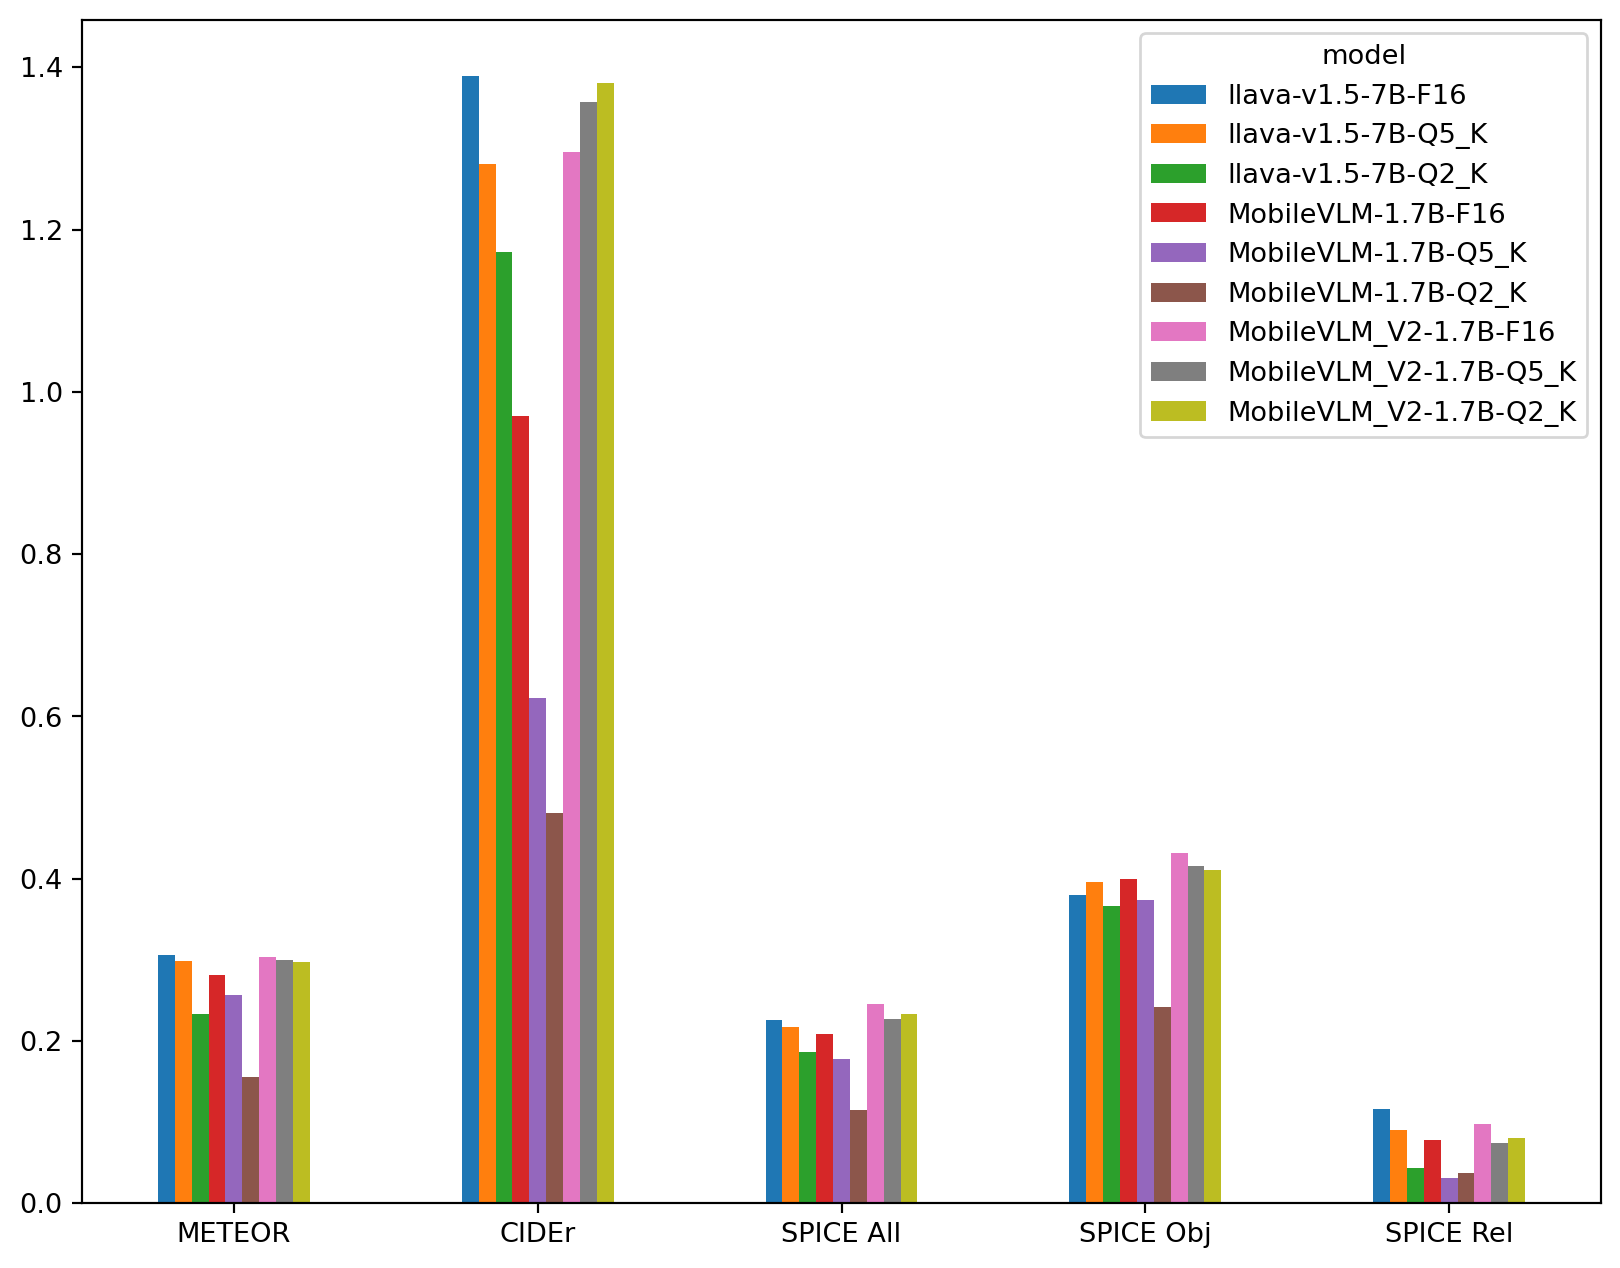

In [16]:
# TODO ipympl and %matplotlib notebook

ax = summary[['METEOR', 'CIDEr', 'SPICE All', 'SPICE Obj', 'SPICE Rel']].transpose().plot.bar()
plt.xticks(rotation=0)
ax

<Axes: title={'center': 'CIDEr score'}, xlabel='model'>

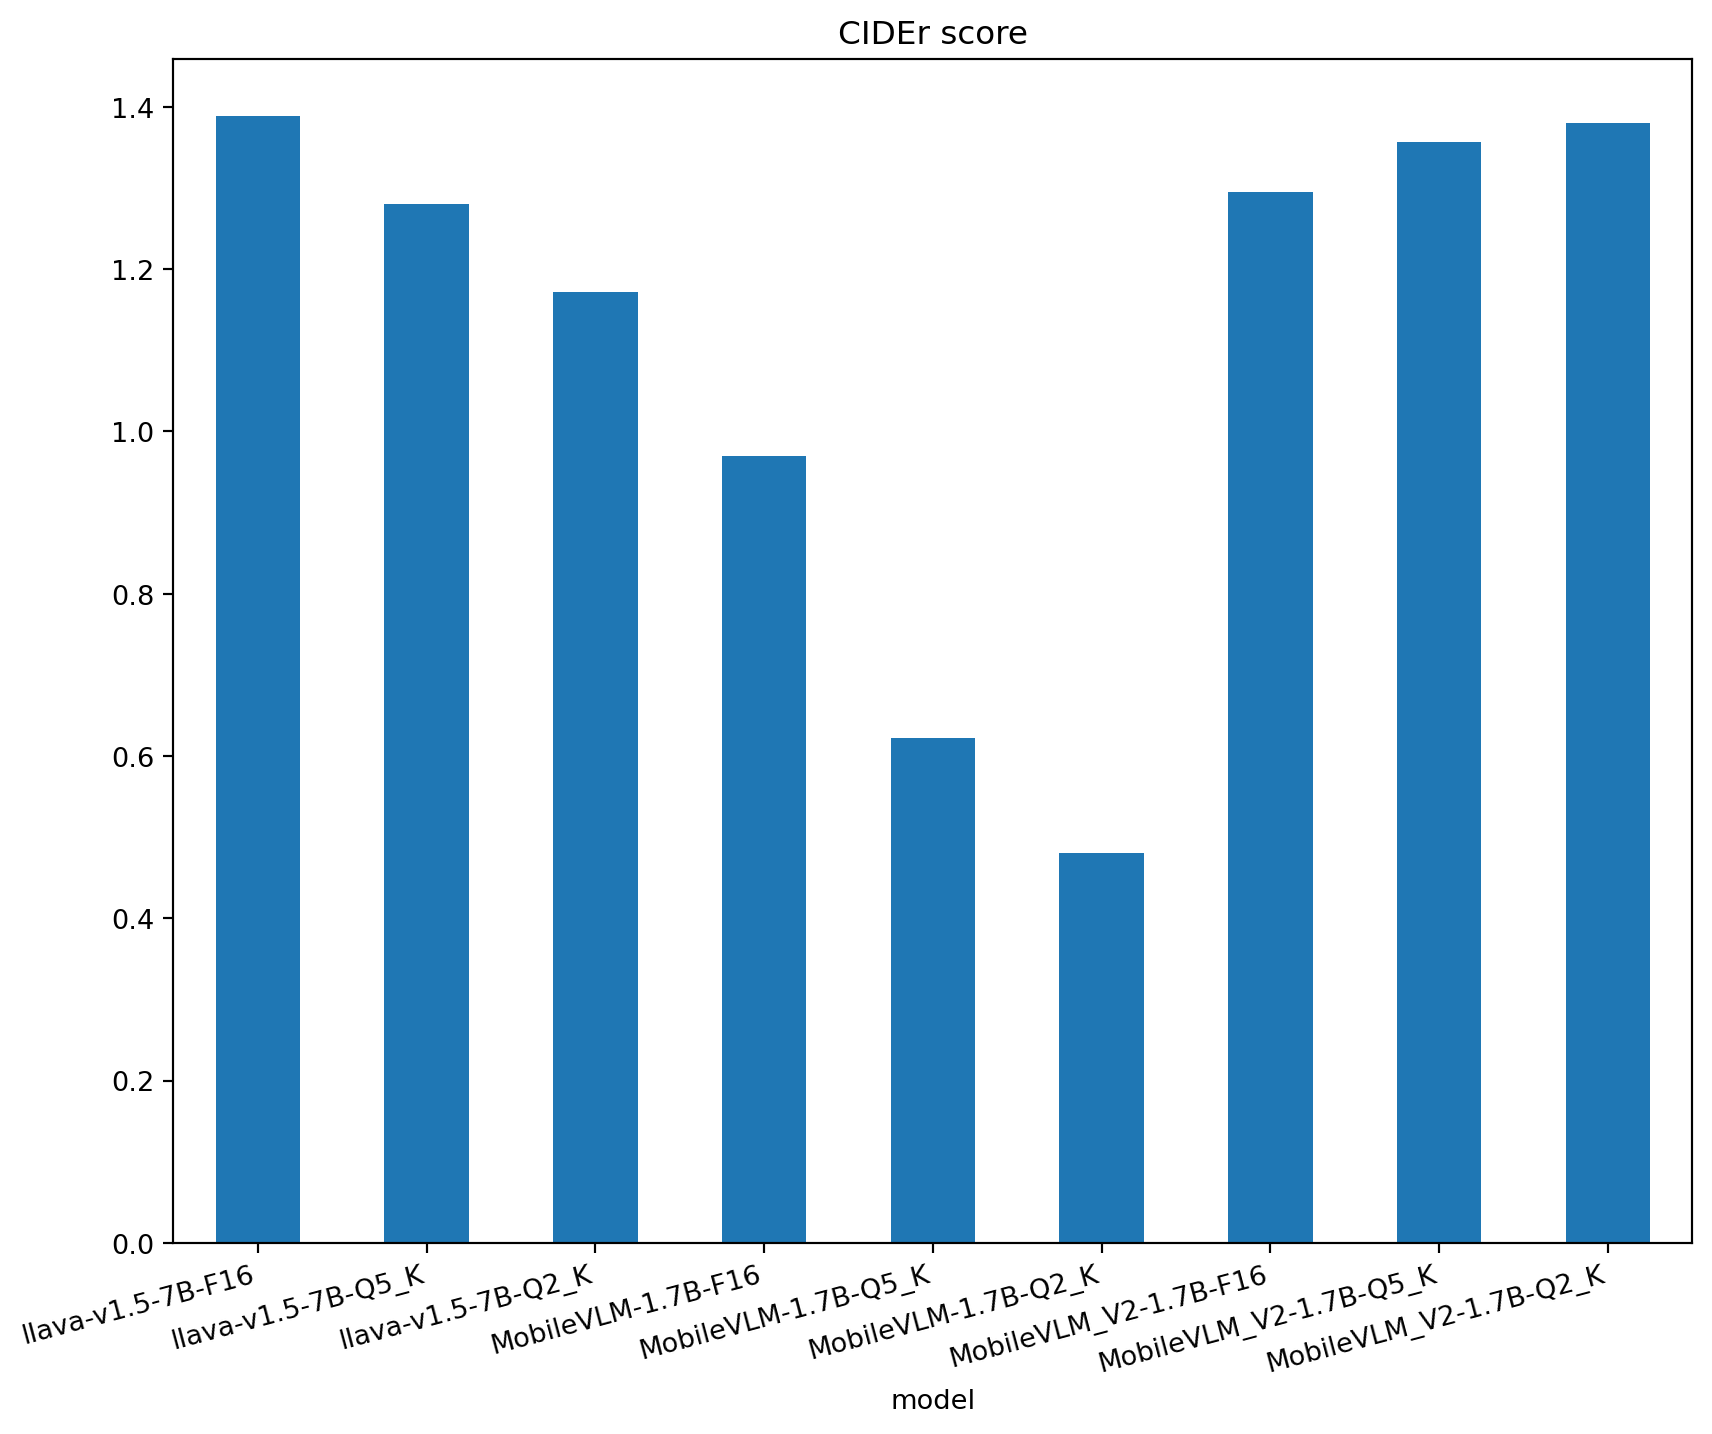

In [30]:
ax = summary['CIDEr'].plot.bar()
plt.xticks(rotation=15, ha='right')
plt.title('CIDEr score')
ax

<Axes: title={'center': 'SPICE overall score'}, xlabel='model'>

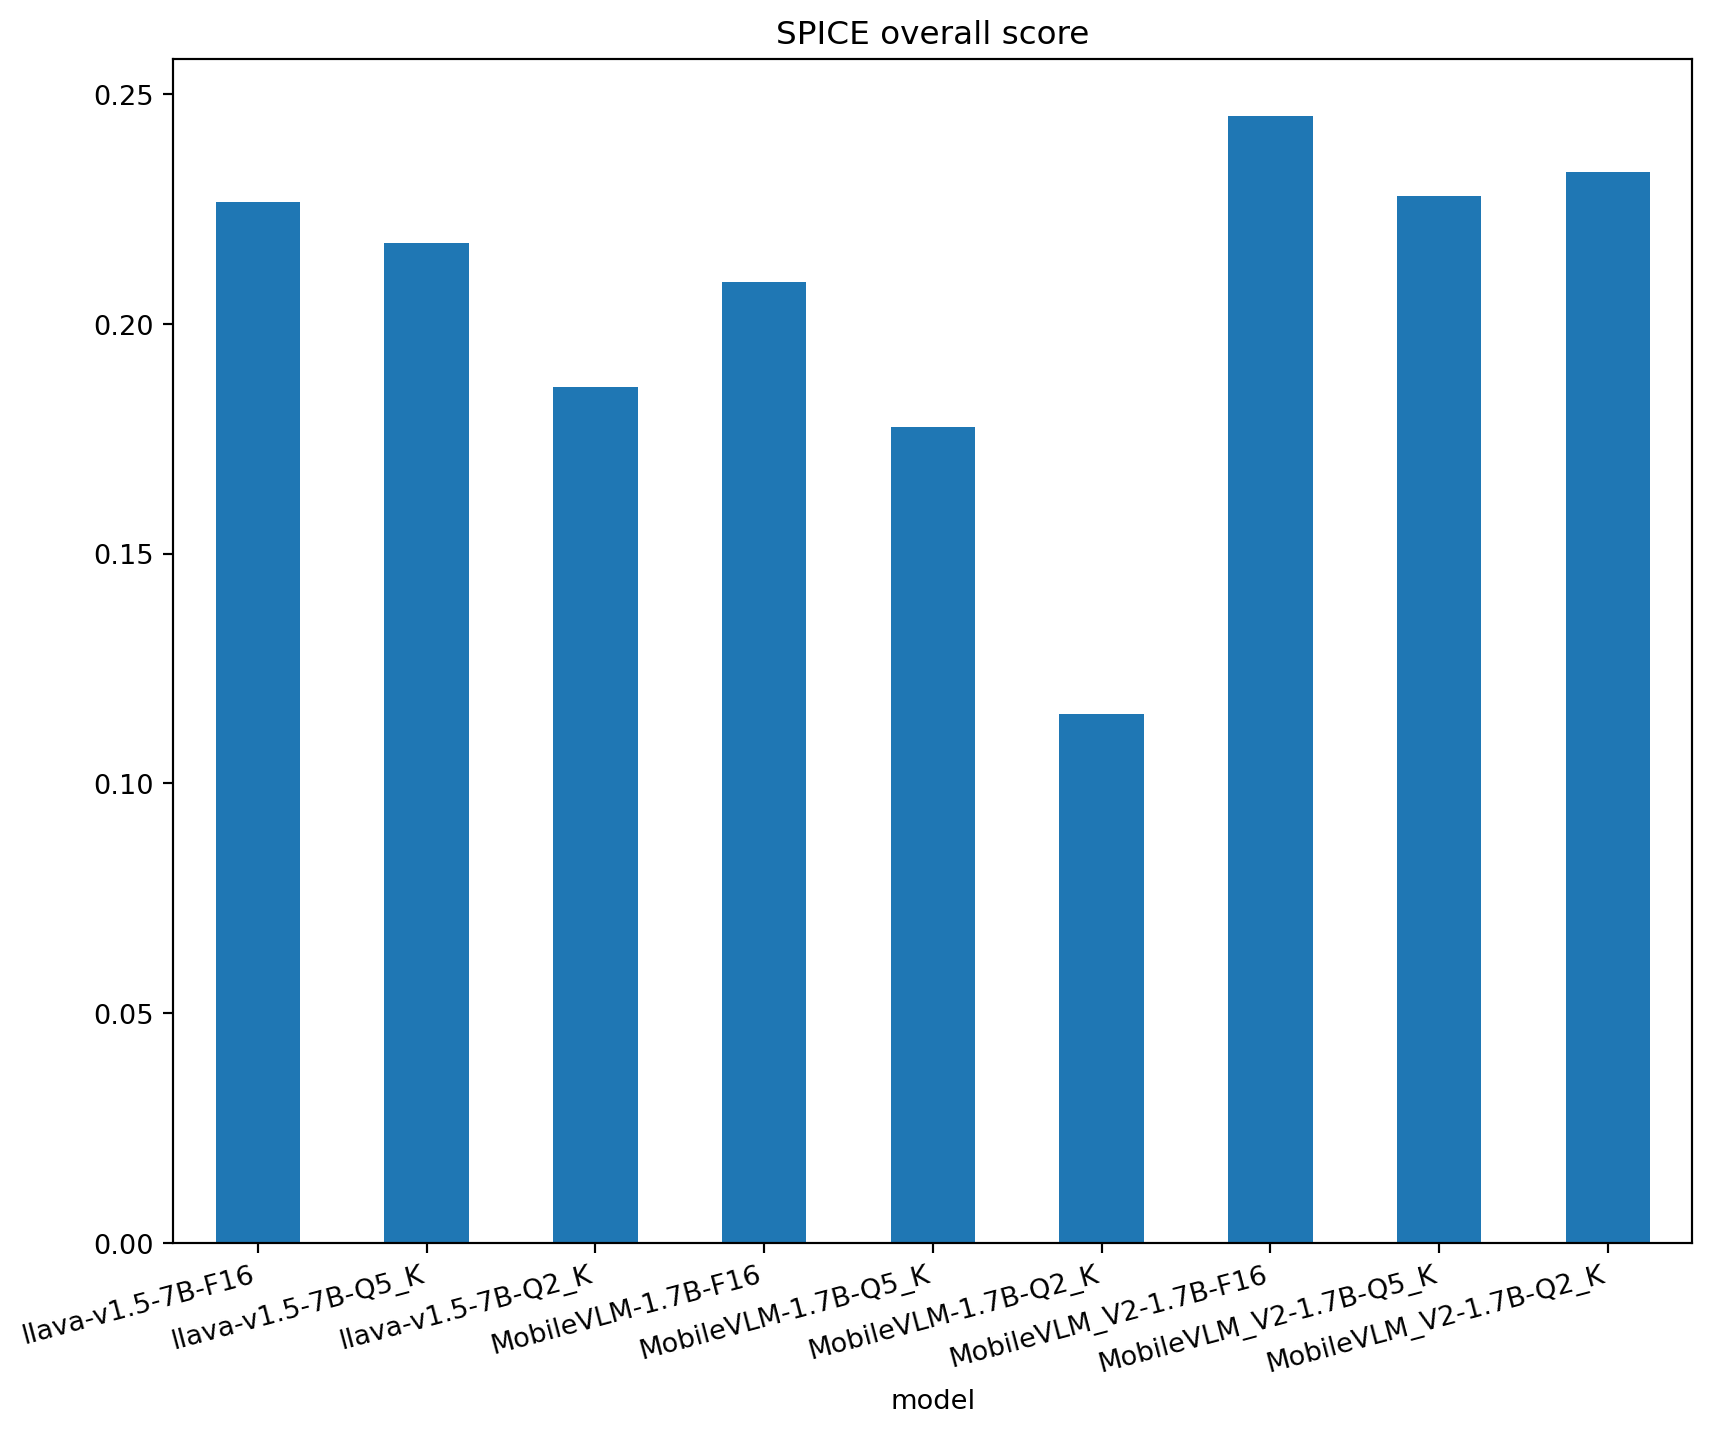

In [31]:
ax = summary['SPICE All'].plot.bar()
plt.xticks(rotation=15, ha='right')
plt.title('SPICE overall score')
ax